# Study energy resolution for low-threshold hits (contained and not)


### Nov 2020, JAH

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy             as np
import pandas            as pd
import tables            as tb
import matplotlib.pyplot as plt

to_df = pd.DataFrame.from_records

In [3]:
import hipy.utils        as ut
import hipy.pltext       as pltext
import hipy.hfit         as hfit

import bes.bes           as bes
import bes.pltbes        as pltbes
import bes.chits         as chits

In [4]:
pltext.style()

import warnings
warnings.filterwarnings('ignore')

import time
print(' Last revision ', time.asctime())

 Last revision  Fri Nov 27 12:35:15 2020


### Load data

In [5]:
runs   = [8182, 8183, 8184]
fnames = [bes.get_esmeralda_filename(run)  for run in runs]
dfts   = [bes.get_esmeralda_dfcomposite(fname) for fname in fnames]
dft    = bes.df_concat(dfts, runs)

In [6]:
selections, ranges = bes.get_selections_dfcomposite(dft)

### Consider the contained low-threshold hits events

In [21]:
### load run-event list of contained and non-contained for ds
fname = './events_lowTh_hits_contained.h5'
for sample in ['ds', 'ph']:
    
    dfcon  = pd.read_hdf(fname, sample + '.contained')
    #print('contained ', sample, len(dfcon))
    selections.set_isin(dfcon, 'lthits.' + sample + '.contained')
    dfncon = pd.read_hdf(fname, sample + '.non_contained')
    #print('non contained ', sample, len(dfncon))
    selections.set_isin(dfncon, 'lthits.' + sample +'.non_contained');

    selections.logical_and(('fidutial.' + sample, 'lthits.' + sample +'.contained'),
                           'fidutial.' + sample + '.contained')
    selections.logical_and(('fidutial.' + sample, 'lthits.' + sample +'.non_contained'), 
                           'fidutial.' + sample +'.non_contained')
    
    selections.logical_and(('fidutial.' + sample, 'dz_track.' + sample), 
                            'fidutial.' + sample + '.dz')
    selections.logical_and(('fidutial.' + sample, 'dz_track.' + sample, 
                            'lthits.' + sample +'.contained'),
                           'fidutial.' + sample + '.dz.contained')
    selections.logical_and(('fidutial.' + sample, 'dz_track.' + sample,
                            'lthits.' + sample +'.non_contained'), 
                           'fidutial.' + sample +'.dz.non_contained')


    
print(selections.keys())

overwriting  fidutial.ds.contained  selection
overwriting  fidutial.ds.non_contained  selection
overwriting  fidutial.ds.dz.contained  selection
overwriting  fidutial.ds.dz.non_contained  selection
overwriting  fidutial.ph.contained  selection
overwriting  fidutial.ph.non_contained  selection
overwriting  fidutial.ph.dz.contained  selection
overwriting  fidutial.ph.dz.non_contained  selection
dict_keys(['numb_of_tracks.one', 'evt_out_of_map.False', 'energy', 'energy.cs', 'energy.ds', 'energy.ph', 'enecor.cs', 'enecor.ds', 'enecor.ph', 'z_min', 'z_max', 'r_max', 'dz_track.cs', 'dz_track.ds', 'dz_track.ph', 'fidutial', 'fidutial.cs', 'fidutial.ds', 'fidutial.ph', 'lthits.ds.contained', 'lthits.ds.non_contained', 'fidutial.ds.contained', 'fidutial.ds.non_contained', 'lthits.ph.contained', 'lthits.ph.non_contained', 'fidutial.ph.contained', 'fidutial.ph.non_contained', 'fidutial.ds.dz.contained', 'fidutial.ds.dz.non_contained', 'fidutial.ph.dz.contained', 'fidutial.ph.dz.non_contained', 'f

In [22]:
print(selections)

numb_of_tracks.one : numb_of_tracks [0.5, 1.5), 1742048, 0.54361
evt_out_of_map.False : evt_out_of_map [False, False], 2755197, 0.85977
energy : energy [0.0, 3.0), 3204248, 0.99990
energy.cs : energy [0.65, 0.71), 68703, 0.02144
energy.ds : energy [1.55, 1.75), 25361, 0.00791
energy.ph : energy [2.5, 3.0), 1461, 0.00046
enecor.cs : enecor [0.65, 0.71), 71613, 0.02235
enecor.ds : enecor [1.55, 1.75), 25678, 0.00801
enecor.ph : enecor [2.5, 3.0), 2334, 0.00073
z_min : z_min [50.0, 500.0), 2707418, 0.84486
z_max : z_max [50.0, 500.0), 2741249, 0.85542
r_max : r_max [0.0, 180.0), 2400680, 0.74914
dz_track.cs : dz_track [8.0, 32.0), 1185869, 0.37005
dz_track.ds : dz_track [24.0, 72.0), 229659, 0.07167
dz_track.ph : dz_track [35.0, 130.0), 114231, 0.03565
fidutial : evt_out_of_map [False, False] & numb_of_tracks [0.5, 1.5) & energy [0.0, 3.0) & z_min [50.0, 500.0) & z_max [50.0, 500.0) & r_max [0.0, 180.0), 1112373, 0.34712
fidutial.cs : evt_out_of_map [False, False] & numb_of_tracks [0.5, 1

## Energy for contained/non-contained

evt_out_of_map [False, False] & numb_of_tracks [0.5, 1.5) & energy [0.0, 3.0) & z_min [50.0, 500.0) & z_max [50.0, 500.0) & r_max [0.0, 180.0) & energy [1.55, 1.75)
evt_out_of_map [False, False] & numb_of_tracks [0.5, 1.5) & energy [0.0, 3.0) & z_min [50.0, 500.0) & z_max [50.0, 500.0) & r_max [0.0, 180.0) & energy [1.55, 1.75) & lthits.ds.contained
evt_out_of_map [False, False] & numb_of_tracks [0.5, 1.5) & energy [0.0, 3.0) & z_min [50.0, 500.0) & z_max [50.0, 500.0) & r_max [0.0, 180.0) & energy [1.55, 1.75) & lthits.ds.non_contained
evt_out_of_map [False, False] & numb_of_tracks [0.5, 1.5) & energy [0.0, 3.0) & z_min [50.0, 500.0) & z_max [50.0, 500.0) & r_max [0.0, 180.0) & energy [2.5, 3.0)
evt_out_of_map [False, False] & numb_of_tracks [0.5, 1.5) & energy [0.0, 3.0) & z_min [50.0, 500.0) & z_max [50.0, 500.0) & r_max [0.0, 180.0) & energy [2.5, 3.0) & lthits.ph.contained
evt_out_of_map [False, False] & numb_of_tracks [0.5, 1.5) & energy [0.0, 3.0) & z_min [50.0, 500.0) & z_max [

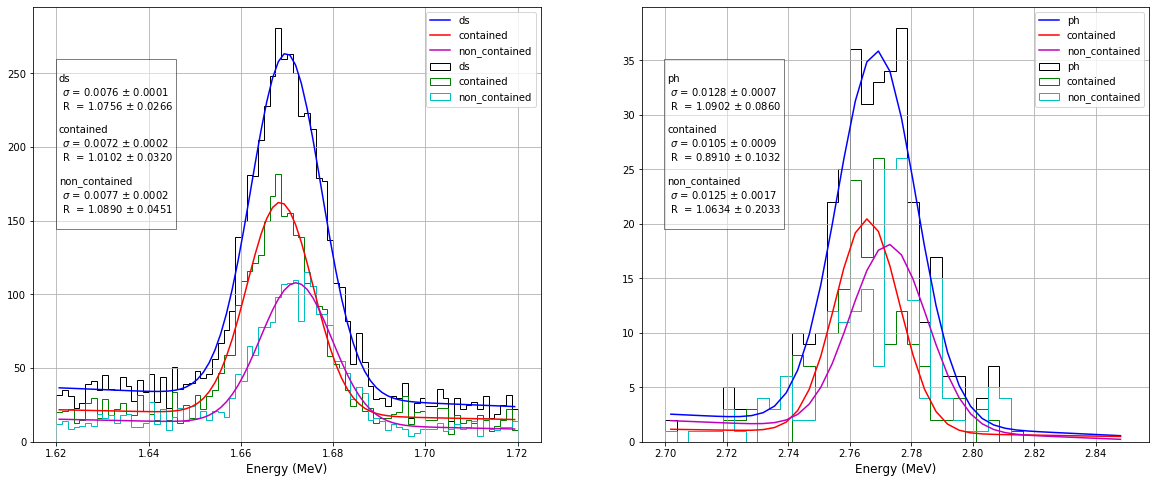

In [23]:
ene = 'enecor'

subplot = pltext.canvas(2, 2, 8, 10)

for i, sample in enumerate(['ds', 'ph']):
    
    subplot( i + 1)

    sels = ['fidutial.' + sample, 
            'fidutial.' + sample + '.contained', 
            'fidutial.' + sample + '.non_contained']

    bins    = 80                        if sample == 'ds' else 40
    range_e = (1.62, 1.72)              if sample == 'ds' else (2.7, 2.85)
    guess   = (100, 1.66, 0.02, 0., 20) if sample == 'ds' else (40, 2.75, 0.02, 0., 10)

    ss = ''
    for sel in sels:
        xsel  = selections[sel]
        print(xsel.info)
        label = sel.split('.')[-1]
        iss, _, _ = pltbes.pfit_energy(dft[xsel][ene], bins, guess = guess, 
                                       label = label, range = range_e, formate = None);
        ss += '\n' + iss
        plt.xlabel('Energy (MeV)', fontsize = 12)
    pltext.plt_text(ss, y = 0.5)


**Conclusions:**
    
   * Event with non-contained hits have slightly worse resolution with normal fidutial cuts.

### Energy resolution with more extrict DZ-selection 

evt_out_of_map [False, False] & numb_of_tracks [0.5, 1.5) & energy [0.0, 3.0) & z_min [50.0, 500.0) & z_max [50.0, 500.0) & r_max [0.0, 180.0) & energy [1.55, 1.75) & dz_track [24.0, 72.0)
evt_out_of_map [False, False] & numb_of_tracks [0.5, 1.5) & energy [0.0, 3.0) & z_min [50.0, 500.0) & z_max [50.0, 500.0) & r_max [0.0, 180.0) & energy [1.55, 1.75) & dz_track [24.0, 72.0) & lthits.ds.contained
evt_out_of_map [False, False] & numb_of_tracks [0.5, 1.5) & energy [0.0, 3.0) & z_min [50.0, 500.0) & z_max [50.0, 500.0) & r_max [0.0, 180.0) & energy [1.55, 1.75) & dz_track [24.0, 72.0) & lthits.ds.non_contained
evt_out_of_map [False, False] & numb_of_tracks [0.5, 1.5) & energy [0.0, 3.0) & z_min [50.0, 500.0) & z_max [50.0, 500.0) & r_max [0.0, 180.0) & energy [2.5, 3.0) & dz_track [35.0, 130.0)
evt_out_of_map [False, False] & numb_of_tracks [0.5, 1.5) & energy [0.0, 3.0) & z_min [50.0, 500.0) & z_max [50.0, 500.0) & r_max [0.0, 180.0) & energy [2.5, 3.0) & dz_track [35.0, 130.0) & lthits.

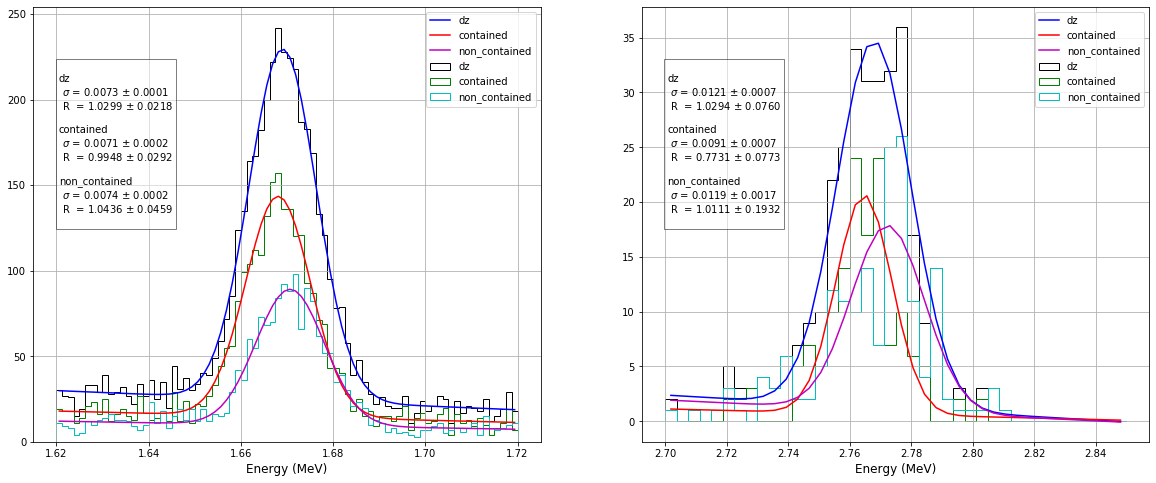

In [24]:
ene = 'enecor'

subplot = pltext.canvas(2, 2, 8, 10)

for i, sample in enumerate(['ds', 'ph']):
    
    subplot( i + 1)

    sels = ['fidutial.' + sample + '.dz' , 
            'fidutial.' + sample + '.dz.contained', 
            'fidutial.' + sample + '.dz.non_contained']

    bins    = 80                        if sample == 'ds' else 40
    range_e = (1.62, 1.72)              if sample == 'ds' else (2.7, 2.85)
    guess   = (100, 1.66, 0.02, 0., 20) if sample == 'ds' else (40, 2.75, 0.02, 0., 10)

    ss = ''
    for sel in sels:
        xsel  = selections[sel]
        print(xsel.info)
        label = sel.split('.')[-1]
        iss, _, _ = pltbes.pfit_energy(dft[xsel][ene], bins, guess = guess, 
                                       label = label, range = range_e, formate = None);
        ss += '\n' + iss
        plt.xlabel('Energy (MeV)', fontsize = 12)
    pltext.plt_text(ss, y = 0.5)

**Conclusions:**
    
   * Event with non-contained hits have worse resolution with tight (dz-range) fidutial cuts.

## Compare DS distributions with contained/non-contained

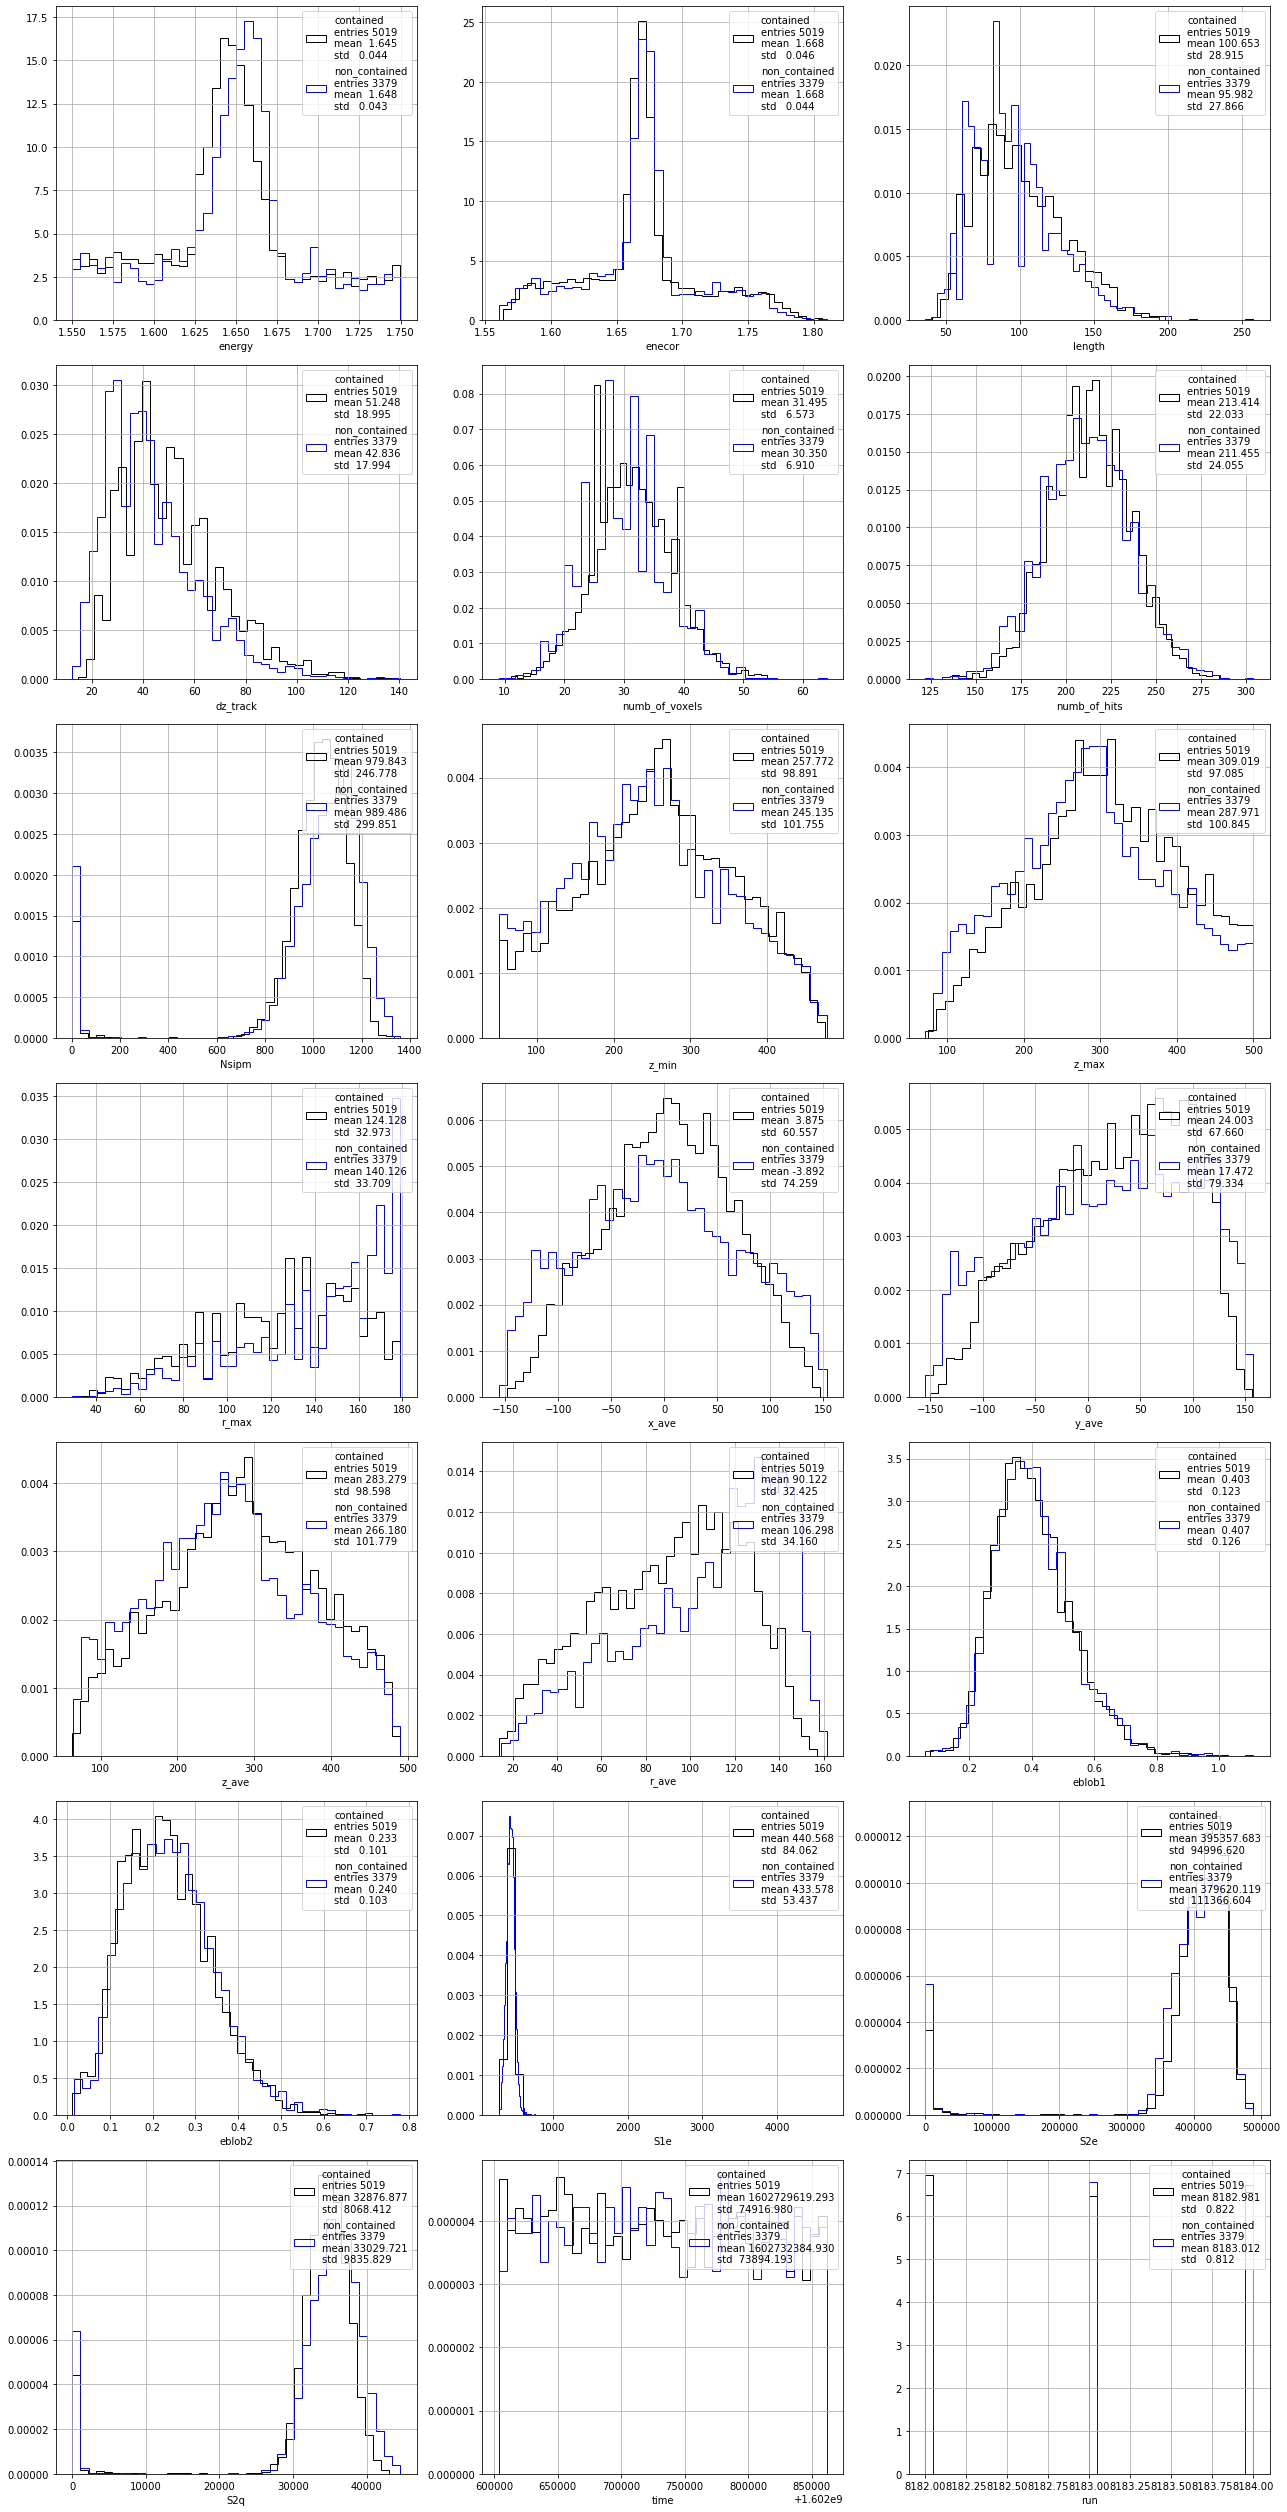

In [13]:
names   = ['fidutial.ds.contained', 'fidutial.ds.non_contained']
dfs     = [dft[selections[name]] for name in names]
dfnames = [name.split('.')[-1]  for name in names] 
labels  = ['energy', 'enecor', 
           'length', 'dz_track', 
           'numb_of_voxels', 'numb_of_hits',  'Nsipm',
           'z_min', 'z_max', 'r_max', 
           'x_ave', 'y_ave', 'z_ave', 'r_ave',
           'eblob1', 'eblob2', 
           'S1e', 'S2e', 'S2q', 
           'time', 'run']

pltext.dfs_inspect(dfs, dfnames, labels, bins = 40, ncolumns = 3)

**Conclusions:**

  * non-contained events are in general: shorter in length and dz-track, closer to the anode, in general large maximum radius. In average are more in the exterior of x, y and radius. Maybe larger charge in SiPMs and PMTs,

## Compare PH distributions contained/non-contained

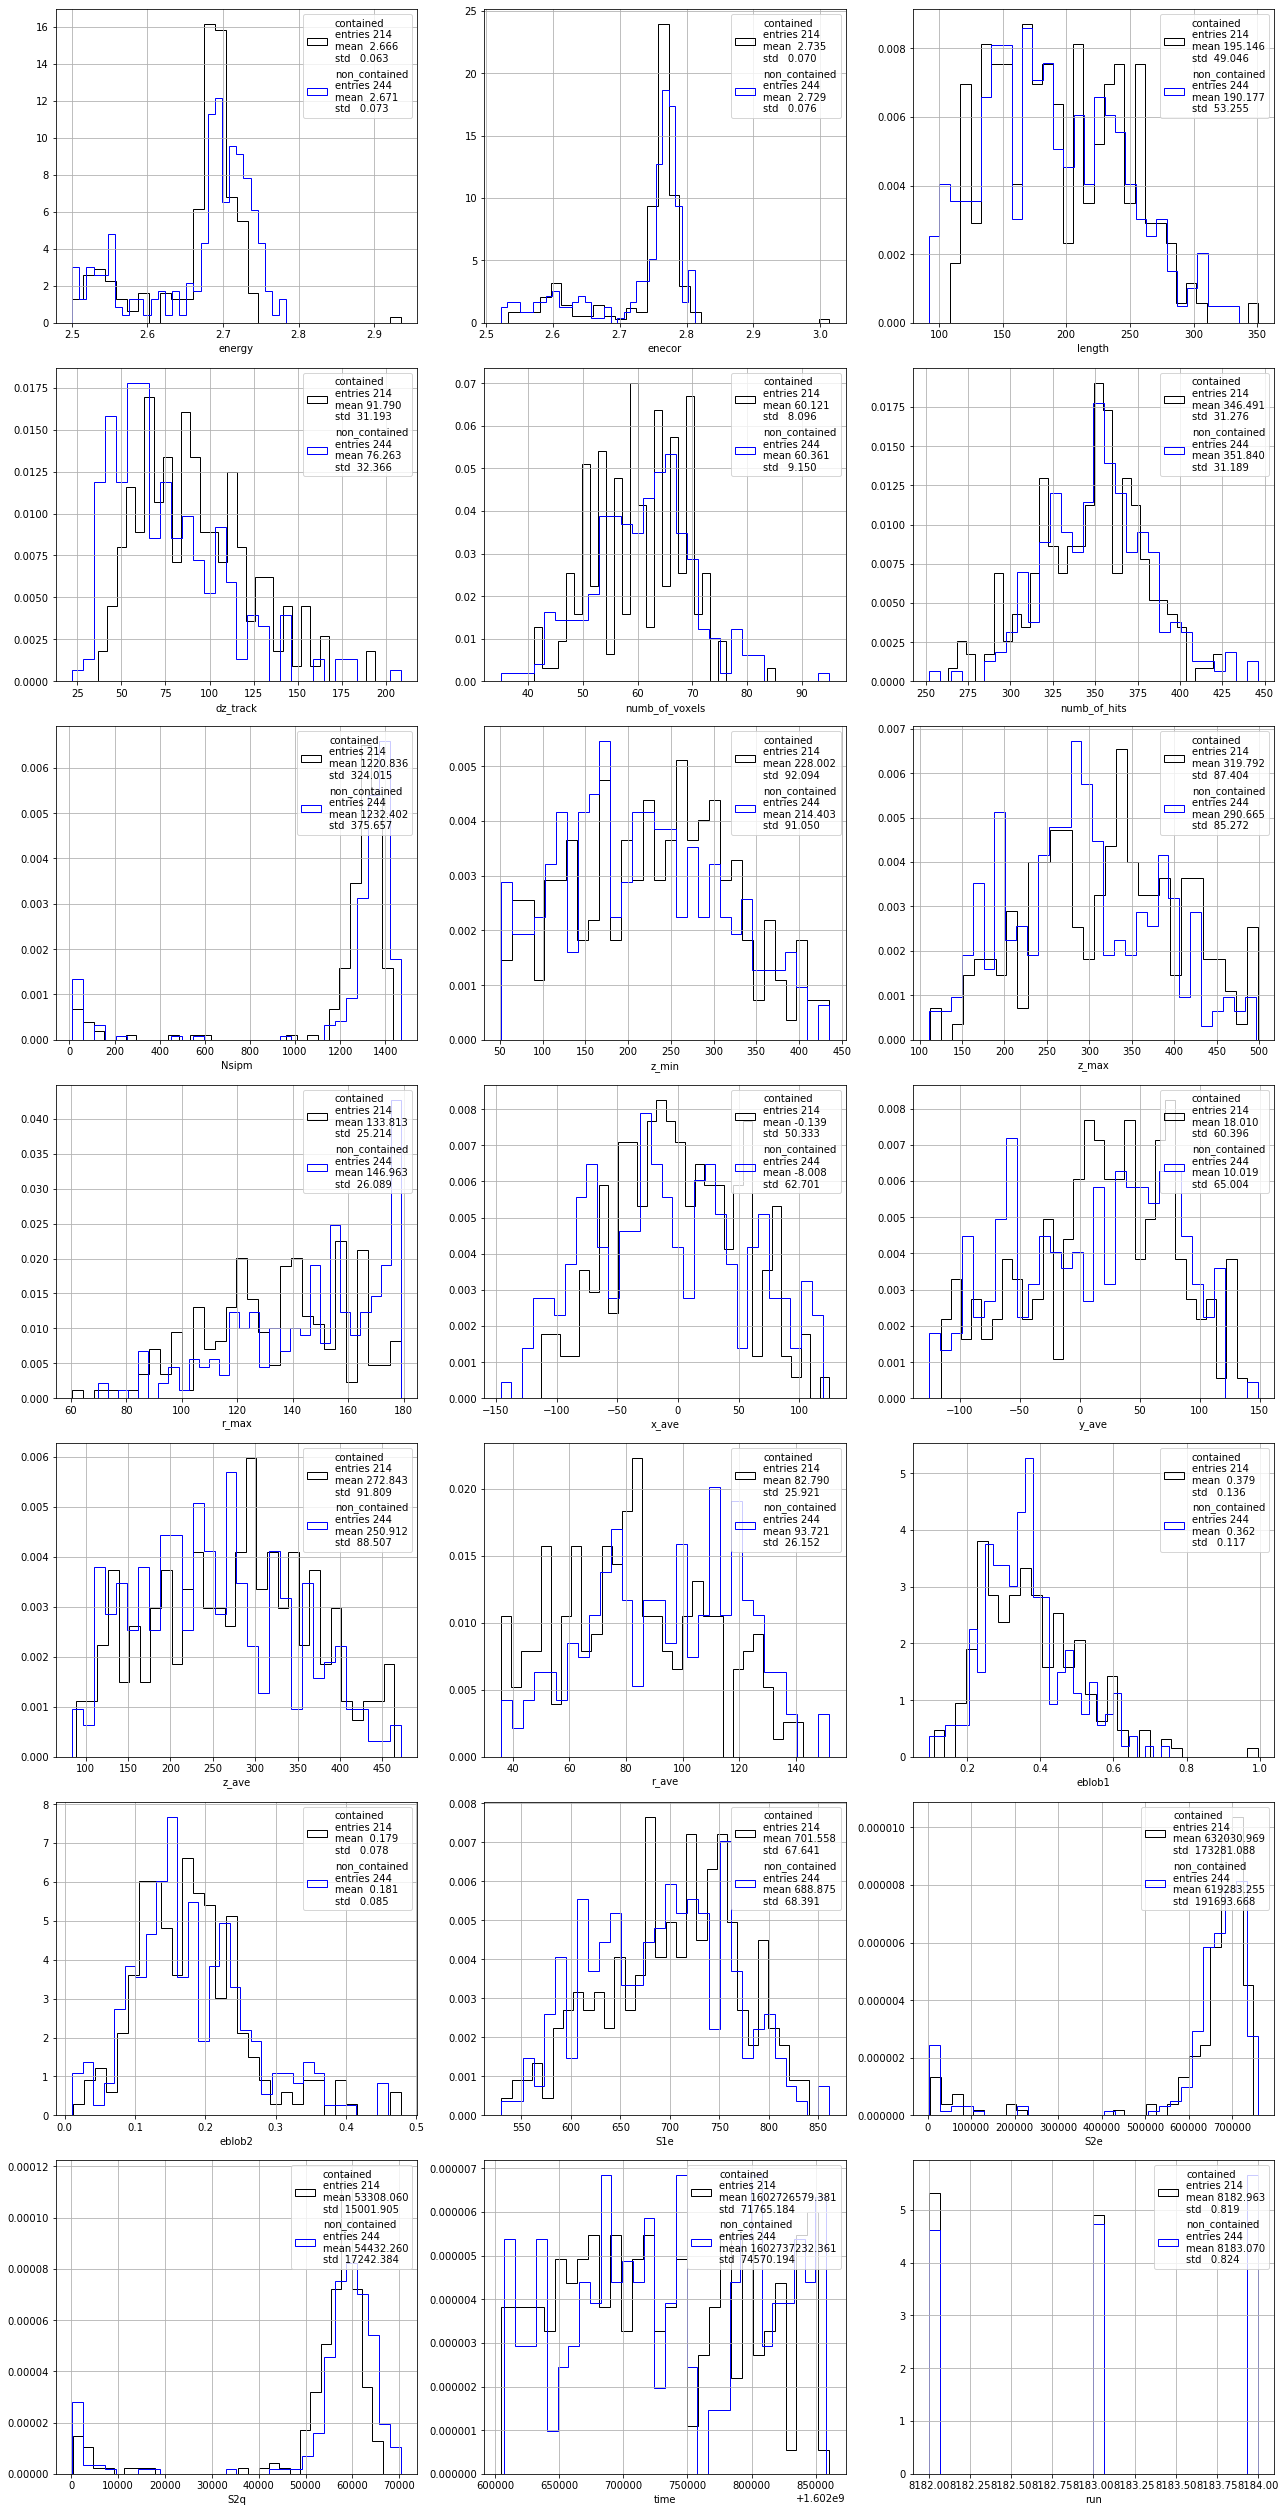

In [14]:
names   = ['fidutial.ph.contained', 'fidutial.ph.non_contained']
dfs     = [dft[selections[name]] for name in names]
dfnames = [name.split('.')[-1]  for name in names] 
labels  = ['energy', 'enecor', 
           'length', 'dz_track', 
           'numb_of_voxels', 'numb_of_hits',  'Nsipm',
           'z_min', 'z_max', 'r_max', 
           'x_ave', 'y_ave', 'z_ave', 'r_ave',
           'eblob1', 'eblob2', 
           'S1e', 'S2e', 'S2q', 
           'time', 'run']

pltext.dfs_inspect(dfs, dfnames, labels, bins = 30, ncolumns = 3)

**Conclusions: **

   * Situation is similar for PH events, non-contained tracks are shorter and close to the anode with larger charge.

## Correlations for contained/non-contained

ds fidutial.ds.contained  :  evt_out_of_map [False, False] & numb_of_tracks [0.5, 1.5) & energy [0.0, 3.0) & z_min [50.0, 500.0) & z_max [50.0, 500.0) & r_max [0.0, 180.0) & energy [1.55, 1.75) & lthits.ds.contained
ds fidutial.ds.non_contained  :  evt_out_of_map [False, False] & numb_of_tracks [0.5, 1.5) & energy [0.0, 3.0) & z_min [50.0, 500.0) & z_max [50.0, 500.0) & r_max [0.0, 180.0) & energy [1.55, 1.75) & lthits.ds.non_contained
ph fidutial.ph.contained  :  evt_out_of_map [False, False] & numb_of_tracks [0.5, 1.5) & energy [0.0, 3.0) & z_min [50.0, 500.0) & z_max [50.0, 500.0) & r_max [0.0, 180.0) & energy [2.5, 3.0) & lthits.ph.contained
ph fidutial.ph.non_contained  :  evt_out_of_map [False, False] & numb_of_tracks [0.5, 1.5) & energy [0.0, 3.0) & z_min [50.0, 500.0) & z_max [50.0, 500.0) & r_max [0.0, 180.0) & energy [2.5, 3.0) & lthits.ph.non_contained


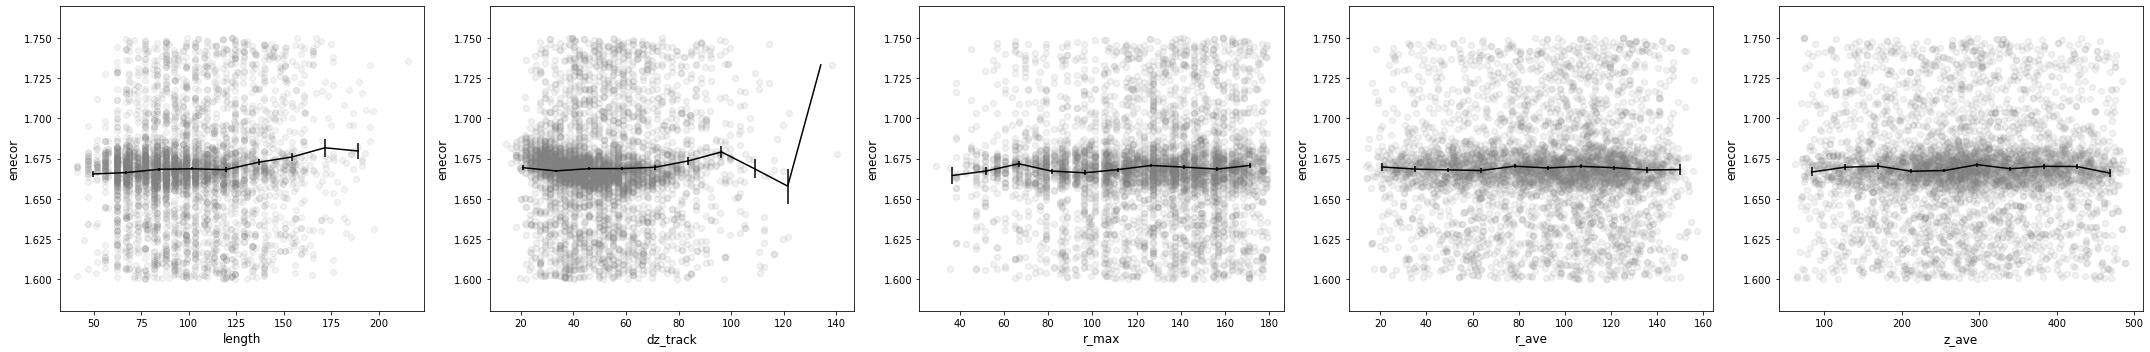

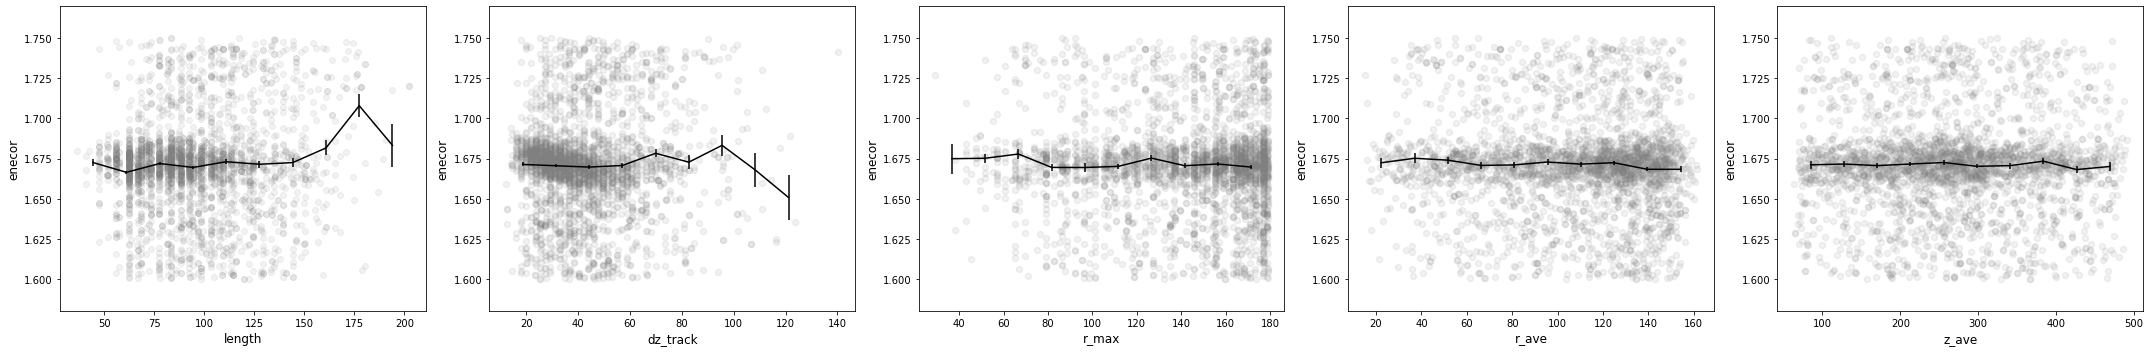

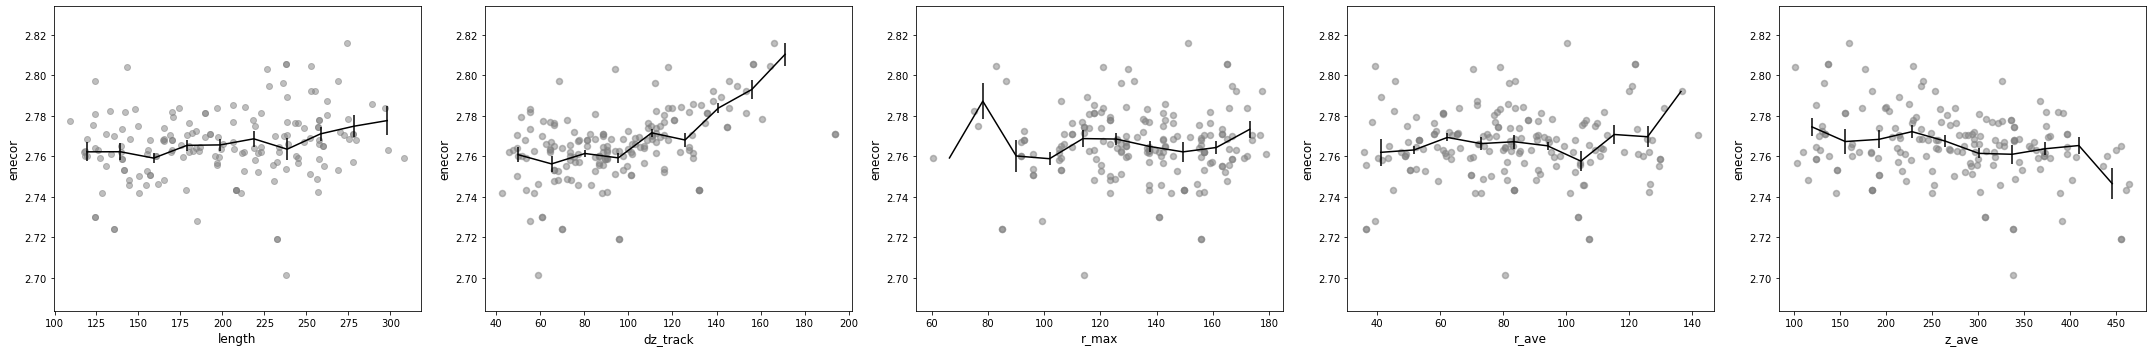

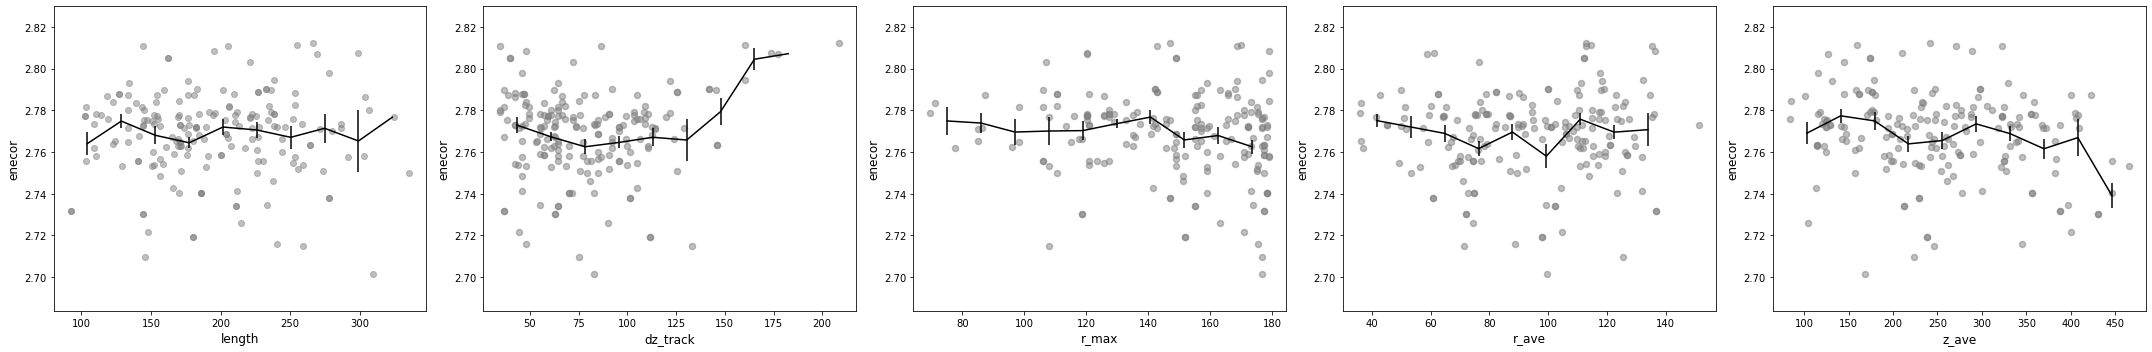

In [35]:
samples = ['ds', 'ph']
label  = 'enecor'
labels = ['length', 'dz_track', 'r_max', 'r_ave', 'z_ave']

for sample in samples:
    erange = (1.6, 1.75) if sample == 'ds' else (2.70, 2.85)
    esel   = ut.in_range(dft.enecor, erange)
    alpha  = 0.1        if sample == 'ds' else 0.5
    selnames = ['fidutial.' + sample + '.contained', 'fidutial.' + sample + '.non_contained']
    for selname in selnames:
        xsel = selections[selname]
        print(sample, selname, ' : ', xsel.info)
        pltext.df_corrprofile(dft[xsel & esel], label, labels, switch = True, alpha = alpha)

**Conclusions:**

  * There is still some bias in the global dz-correction, it looks that the correction has two slopes.
  
  * This is clear for the ph, starting at 100 mm, there is a clear bias.
  
  * For the non-contained events resolutions degrades it maximum radious is 140 or average 110 mm aprox.
  
  * Other dependencies are null.

## Zoom Edz vs dz again

evt_out_of_map [False, False] & numb_of_tracks [0.5, 1.5) & energy [0.0, 3.0) & z_min [50.0, 500.0) & z_max [50.0, 500.0) & r_max [0.0, 180.0) & energy [1.55, 1.75) & lthits.ds.contained
evt_out_of_map [False, False] & numb_of_tracks [0.5, 1.5) & energy [0.0, 3.0) & z_min [50.0, 500.0) & z_max [50.0, 500.0) & r_max [0.0, 180.0) & energy [1.55, 1.75) & lthits.ds.non_contained
evt_out_of_map [False, False] & numb_of_tracks [0.5, 1.5) & energy [0.0, 3.0) & z_min [50.0, 500.0) & z_max [50.0, 500.0) & r_max [0.0, 180.0) & energy [2.5, 3.0) & lthits.ph.contained
evt_out_of_map [False, False] & numb_of_tracks [0.5, 1.5) & energy [0.0, 3.0) & z_min [50.0, 500.0) & z_max [50.0, 500.0) & r_max [0.0, 180.0) & energy [2.5, 3.0) & lthits.ph.non_contained


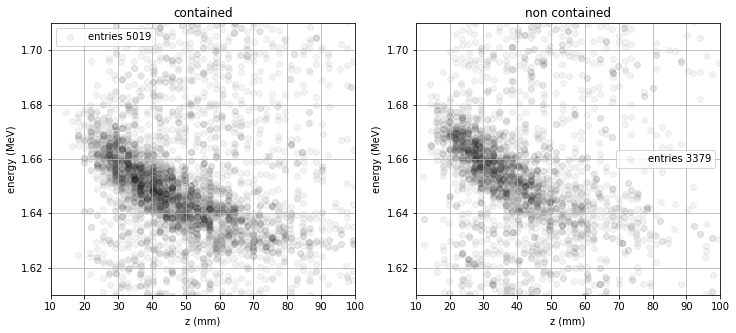

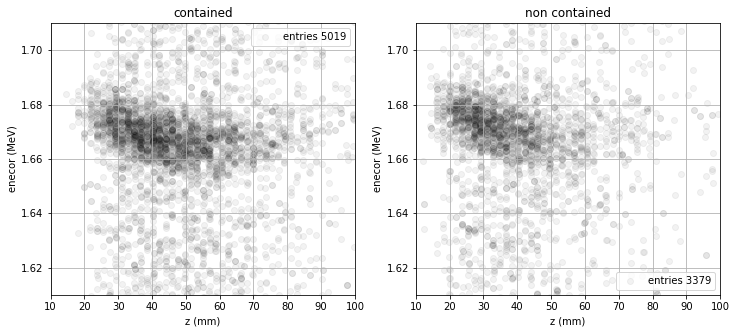

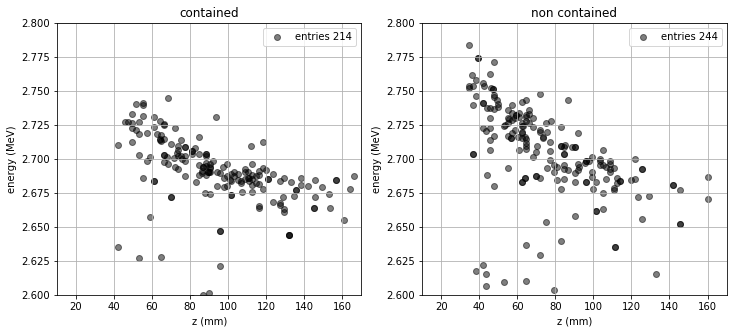

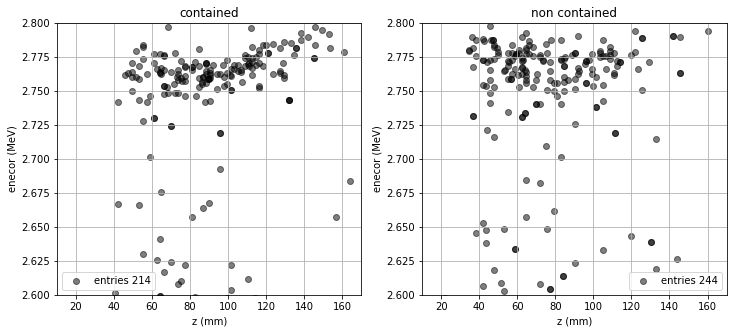

In [45]:
samples   = ['ds', 'ph']

for sample in samples:

    range_y  = (1.61, 1.71)  if sample == 'ds' else (2.6, 2.8)
    range_x  = (10., 100.)   if sample == 'ds' else (10., 170.)
    alpha    = 0.05          if sample == 'ds' else 0.5
    
    xsel = selections[f'fidutial.{sample}.contained']
    print(xsel.info)
    ysel = selections[f'fidutial.{sample}.non_contained']
    print(ysel.info)

    for name in ['energy', 'enecor']:
        
        subplot = pltext.canvas(2)

        subplot(1)
        plt.scatter(dft[xsel].dz_track, dft[xsel][name], alpha = alpha, label = 'entries ' +str(np.sum(xsel)));
        plt.grid(); plt.xlabel('z (mm)'); plt.ylabel(name + ' (MeV)'); plt.legend(); plt.title('contained')
        plt.ylim(range_y); plt.xlim(range_x)
    

        subplot(2)
        plt.scatter(dft[ysel].dz_track, dft[ysel][name], alpha = alpha, label = 'entries ' +str(np.sum(ysel)));
        plt.grid(); plt.xlabel('z (mm)'); plt.ylabel(name + ' (MeV)'); plt.legend(); plt.title('non contained');
        plt.ylim(range_y); plt.xlim(range_x)


**Conclusions:**
    
   * Dz effect seems similar for DS, but different for PH (non-contained have smaller Dz and large E)
   
   * Dz correction is not complete for DS, (seems a overcorrection above 60 mm). It is also a over-correction for PH aboce 110 mm!
